# An example of basic plan checking using mephisto data files

For the completion of the [5.1.2.1 TEAP competency](http://simonbiggs.net/ctg#page=79) I underwent the following training items:

 * Data collection at 90 SSD for Monaco 5.1
 * Derived TMR to PDD conversion and reproduced the basic plan checking formula
 * Adjusted the basic plan checking formula to receive data from a source that was not collected at the same SSD 
 * Wrote a program using python, regular expressions, and sufficient quality checks via assertions to turn the standard mephisto file which has been collated into a range of PDDs for different field sizes into a linear interpolation function for PDDs as a function of depth and field size
 * Calculated Sp and from the 90 SSD data and renormalised to follow the current formalism used at RCCC.
 * Calculated WTF as a function of field size


This following [IPython notebook](http://ipython.org/notebook.html) is a demonstration of the use of the collected mephisto data for the use of a corrections based MU check.

## Overview
This notebook contains the following:
 
 * [Initial packages and data loading](#Initial-loading-of-required-packages-and-data)
   * [Loading PDD data](#Load-PDD-data) into interpolation functions from mephisto files
   * [Loading scatter factors](#Load-scatter-factor-interpolation-functions)
   * [Loading the wedge transmission factor](#Wedge-transmission-factor)
 * Using the data to perform a corrections based plan check on a [clinical patient beam](#Checking-a-patient-beam)
 * Then this is [compared to tolerances](#Comparison-to-expected-deviations-in-different-regions) given by TRS 430
 * At [the end](#Display-the-contents-of-the-python-scripts-used-within-this-notebook) of this notebook I present the raw scripts used to actually pull the data from the file.



## Data measurement

All water tank data was measured at 90 SSD according to the requirements for Monaco 5.1 data collection. $S_c$ was measured at 100 SCD with a semiflex chamber with a brass build up cap. $S_{cp}$ was measured using the semiflex for field sizes $\geq 5\times5~$cm and the pinpoint was daisy chained at the $5\times5~$cm field size and used for the measurements down to $2\times2~$cm. Measurements for $S_{cp}$ were at 90 SSD measured at 10 cm depth.

Data for the PDDs was measured using a semiflex ion chamber and the geometric effective depth of measurement was applied as a shift in the water tank such that the recorded mephisto depth is the actual depth of PDD. No post processing shift of depth is required. PDDs were collated into a single mephisto file over the range of field sizes. PDDs were smoothed.

The wedge transmission factor was measured with the semiflex at 90 SSD at 10 cm depth.

## Initial loading of required packages and data
The cell imediately below is simply an initialisation cell which imports the python modules being used throughout this notebook.

In [1]:
from glob2 import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from rtplanchecking.pull_mephisto import *
from rtplanchecking.scatter_factors import *

from scipy.interpolate import interp1d

### Load PDD data
Here I create PDD functions that recieve the inputs field size and depth and linearly interpolate between the collected mephisto data. This was done by taking the raw mephisto .mcc files and using the function `create_pdd_function()` that I defined within [`pull_mephisto.py`](#Mephisto-pull).

In [2]:
open_pdd_data_filepath = glob("data/**/6MV*Open*PDD*.mcc")[0]
wedge_pdd_data_filepath = glob("data/**/6MV*Wedge*PDD*.mcc")[0]

open_pdd = create_pdd_function(open_pdd_data_filepath, SSD=90)
wedge_pdd = create_pdd_function(wedge_pdd_data_filepath, SSD=90)

Examples of these PDD functions in use is given below:

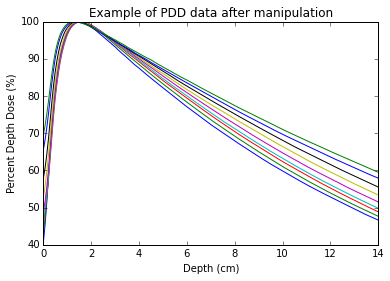

In [3]:
example_field_size = np.array([2,3,4,5,7,10,15,25,40])**2
example_depths = np.linspace(0, 14, 200)

plt.plot(example_depths, open_pdd(example_depths, example_field_size))

plt.ylim([40, 100])
plt.title('Example of PDD data after manipulation')
plt.xlabel('Depth (cm)')
plt.ylabel('Percent Depth Dose (%)');

### Load scatter factor interpolation functions
Here I create the interpolation functions for Sc and Sp. They make use of the function `create_scatter_functions()` that I defined within [`scatter_factors.py`](#Define-scatter-factors).

In [4]:
scatter_factor_filepath = 'data/scatter_factors_6MV.csv'
result = create_scatter_functions(
    scatter_filepath=scatter_factor_filepath, 
    pdd_filepath=open_pdd_data_filepath,
    SSD_data=90)
Sc = result['Sc']
Scp = result['Scp']
Sp = result['Sp']

result = create_wedge_functions(
    scatter_filepath=scatter_factor_filepath, 
    pdd_filepath=wedge_pdd_data_filepath,
    SSD_data=90)
Sc_wedge = result['Sc_wedge']
Sp_wedge = result['Sp_wedge']

Examples of these scatter factor functions are shown below

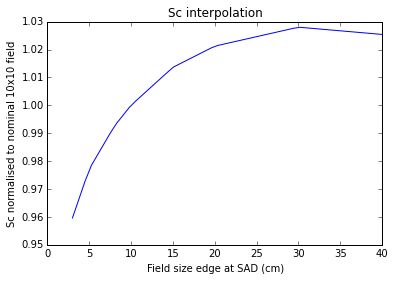

In [5]:
example_field_size = np.linspace(3,40)**2
plt.plot(np.sqrt(example_field_size), Sc(example_field_size))

plt.title('Sc interpolation')
plt.xlabel('Field size edge at SAD (cm)')
plt.ylabel('Sc normalised to nominal 10x10 field');

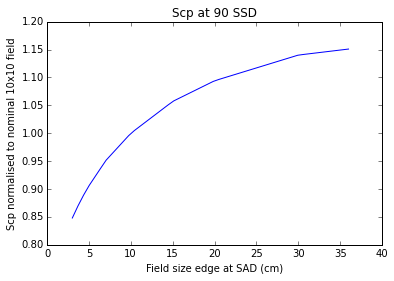

In [6]:
example_field_size = np.linspace(3,40*.9)**2
plt.plot(np.sqrt(example_field_size), Scp(example_field_size))

plt.title('Scp at 90 SSD')
plt.xlabel('Field size edge at SAD (cm)')
plt.ylabel('Scp normalised to nominal 10x10 field');

#### Demonstration of how the raw data was converted into Sp

 $S_{cp}$ was measured at 90 SSD and normalised to the nominal 10x10 field. This means that following the standard $S_p$ calculation from $S_{cp}$ and $S_c$ would result in an $S_p$ normalised at the surface about a 9x9 field. This would disagree with the calibration conditions which are at isocentre for which the surface of the water (at 100 SSD) has a 10x10 field.

Furthermore all data was measured at 10 cm depth. Therefore all $S_{cp}$ measurements needed to be first corrected back to $d_{max}$ before further calculation.

This was achieved in two stages. The first stage was to create an `Sp_not_normalised()` function. This calculated $S_p = \frac{S_{cp}}{S_c}$, and then corrected back to $d_{max}$ making sure to correctly use the 9x9 surface area for the PDD correction as this is how the data was measured.

In [7]:
SSD_data = 90
SSD_cal = 100
calibration_field_area = 100

def Sp_not_normalised(area_surface):
    area_reference = calibration_field_area * (SSD_data / SSD_cal) ** 2

    area_iso = area_surface / (SSD_data / SSD_cal) ** 2
    Sp_uncorr = Scp(area_iso) / Sc(area_iso)
    pdd_correction = (
        open_pdd(10, area_reference) / open_pdd(10, area_surface))
    return Sp_uncorr * np.squeeze(pdd_correction)

Then to normalise $S_p$ according to the calibration conditions the function $S_p$ divides through by the resulting $S_p$ from the `calibration_field_area` variable.

In [8]:
def Sp(area_surface):
    return (
        Sp_not_normalised(area_surface) /
        Sp_not_normalised(calibration_field_area))

This results in the following $S_p$ interpolation fuction:

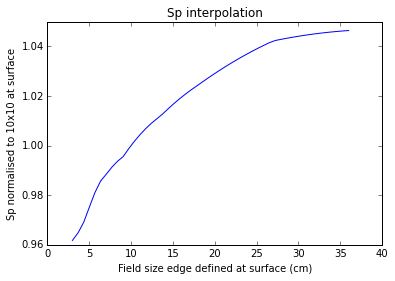

In [9]:
example_field_size = np.linspace(3,40*.9)**2
plt.plot(np.sqrt(example_field_size), Sp(example_field_size))

plt.title('Sp interpolation')
plt.xlabel('Field size edge defined at surface (cm)')
plt.ylabel('Sp normalised to 10x10 at surface');

### Wedge transmission factor

The wedge transmission factor was pulled and was PDD corrected to be defined at $d_{max}$. This was done using the correction:


$$\frac{\textit{PDD}_\textit{open}(d=10\textit{ cm}, \textit{ fs}=9\times9\textit{ cm})}{\textit{PDD}_\textit{wedge}(d=10\textit{ cm}, \textit{ fs}=9\times9\textit{ cm})}$$

In [10]:
wedge_transmission_factor_data = pd.DataFrame.from_csv(
    'data/wedge_transmission_factor.csv')
wtf_at_10 = wedge_transmission_factor_data['wtf_at_10cm']['6MV']
wtf_at_dmax = wtf_at_10 * open_pdd(10, 81) / wedge_pdd(10, 81)
wtf_at_dmax

array([[ 0.25678122]])

## Checking a patient beam

A particular isocentric wedged beam that was within a regular patient plan to be checked was calculated below.

### Patient data from XiO's report in Mosaiq
The following is the data written in from XiO's report found on the patient file within Mosaiq

In [11]:
field_area_colimator = 50
field_area_patient = 50
SSD = 97.1
depth = 2.9
SAD = 100
SSD_data = 90
eff_depth = 2.8

fractions = 8

open_MU = 31.89
wedge_MU = 281.68

XiO_dose = 800

An SSD correction is made to determine the field size at the surface of the patient as defined along the CRA rayline

In [12]:
field_area_surf = field_area_patient * ((SSD)/(SSD + depth))**2
field_area_surf

47.14205

$d_{max}$ is pulled from the PDD data

In [13]:
depth_lookup = np.linspace(0,10,1001)
pdd_lookup = open_pdd(depth_lookup, field_area_surf)
dmax = depth_lookup[np.argmax(pdd_lookup)]
dmax

1.6000000000000001

For easier reading an inverse correction function is made

In [14]:
def inv_corr(a,b):
    return (a/b)**2

The open dose is defined as following. This takes into account correcting the PDD collected at 90 SSD to the calibration SSD of 100 SSD, then it corrects the SSD to the patient SSD. Furthermore the effective depth is taken into account using the effective depth.

In [15]:
open_dose = (
    open_MU * open_pdd(eff_depth, field_area_surf)/100 * 
    inv_corr(SSD + eff_depth, SSD + depth) *
    inv_corr(SAD + dmax, SSD_data + dmax) *
    inv_corr(SSD_data + depth, SSD + depth) *
    Sc(field_area_colimator) * Sp(field_area_surf)
)
open_dose

array([[ 31.49897483]])

Wedge is calculated similarly, however the wedge pdds are used and the wedge transmission factor is included.

In [16]:
wedge_dose = (
    wedge_MU * wedge_pdd(eff_depth, field_area_surf)/100 * 
    inv_corr(SSD + eff_depth, SSD + depth) *
    inv_corr(SAD + dmax, SSD_data + dmax) *
    inv_corr(SSD_data + depth, SSD + depth) *
    Sc_wedge(field_area_colimator) * Sp_wedge(field_area_surf) *
    wtf_at_dmax
)
wedge_dose

array([[ 70.40328267]])

In [17]:
total_dose = open_dose + wedge_dose
total_dose

array([[ 101.9022575]])

In [18]:
fractions * total_dose

array([[ 815.21806]])

When compared to the XiO dose the deviation is 1.9%

In [19]:
fractions * total_dose / XiO_dose

array([[ 1.01902257]])

## Comparison to expected deviations

This calculation was performed on the central beam axis. In [IAEA TRS 430](http://www-pub.iaea.org/mtcd/publications/pdf/trs430_web.pdf#page=76) is presented the figure and table coupied in below. In our scenario there is a wedge and slight inhomogeneity. The 95% confidence interval tollerance under this scenario is quoted as 3%. For this example beam the indepentent MU check agrees with the XiO planning system to within that tolerance. 



#### Table 18 within TRS 430
![Table 18 within TRS 430](http://simonbiggs.net/teap/5.1.2.1/TRS430_tbl18.png)

#### Figure 11 within TRS 430
![Figure 11 within TRS 430](http://simonbiggs.net/teap/5.1.2.1/TRS430_fig11.png)

## Display the contents of the python scripts used within this notebook

For reference the contents of the python user scripts imported within this notebook are displayed below

In [20]:
from IPython.display import HTML

from rtplanchecking.utilities import print_file_code

pull_mephisto_html = print_file_code('rtplanchecking/pull_mephisto.py')
scatter_factors_html = print_file_code('rtplanchecking/scatter_factors.py')
utilities_html = print_file_code('rtplanchecking/utilities.py')

### Mephisto pull

In [21]:
HTML(pull_mephisto_html)

### Define scatter factors
As a note to self. These functions woulf better defined by simply taking a range of raw data values. Not the filepath. That way they will be significantly more modular, and both the wedge and open would be able to be collapsed into one.

In [22]:
HTML(scatter_factors_html)

### The code that produces these file prints

In [23]:
HTML(utilities_html)